# Python Peer-to-Peer Energy Sharing Optimization Library (PyPESOL)

<img src="logo.png" width=100 height=100 />

## A Brief Getting Started Guide

This simple guide allows to get started with PyPESOL. Let's illustrate the functionalities of the optimizer on a small example provided in the folder **data_test**. The data provided as part of this tiny example is purely arbitrary.

Let's first start by initializing an optimizer based on the data in that folder.

In [1]:
from optimizer import *
import os.path

opt = Optimizer.from_folder2("data_test")

print("OK, optimizer loaded in memory!")

OK, optimizer loaded in memory!


The optimizer is built to calculates the (optimal) electricity cost of a set of end-users. It relies on 5 types of data and a few constant values:
- $B_u$ the battery capacity (kWh) of user u (for all users)
- $PV_u$ the PV capacity (kWp) of user u (for all users)
- $cons(u,t)$ the hourly consumption profile (kWh) of user $u$ over a certain time period $t \in T$
- $sun(u,t)$ the solar profile (kWh/kWp) of user $u$ over a certain time period $t \in T$; alternatively, this can be directly the electricity generation of user $u$ when setting $PV_u = 1$
- $price(t)$ the price (e.g. in €/kWh) over the time period $t \in T$ (assumed the same for all users)
- $tax$ the level of tax
- $el_{tax}$ added tax (e.g. in €/kWh) on top of market price when buying from the grid
- $el_{net}$ added benefit (e.g. in €/kWh) on top of market price when selling to the grid

Let's inspect the example data. It contains 4 users: the first one is a prosumer with a battery of 10 kWh and a PV capacity of 5 kWp, while the 3rd user has a battery of 5 kWh and PV capacity of 2 kWp. The second and fourth ones are usual consumers that has no resource. The variables `opt.battery` and `opt.pv` are arrays stroing the battery and PV capacities for all user $u_1, \dots, u_n$:

In [2]:
opt.battery

array([10.,  0.,  5.,  0.])

In [3]:
opt.pv

array([5., 0., 2., 0.])

Consumptions are stored in the 2d-array `opt.cons` where $cons(u,t) =$ `opt.cons[u][t]`. In the example data, 3 days of data are stored. Let's have a first look at the consumptions of the two users:

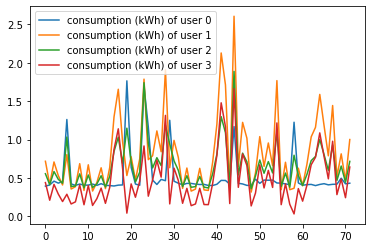

In [4]:
from matplotlib import pyplot as plt

plt.plot(opt.cons[0], label='consumption (kWh) of user 0')
plt.plot(opt.cons[1], label='consumption (kWh) of user 1')
plt.plot(opt.cons[2], label='consumption (kWh) of user 2')
plt.plot(opt.cons[3], label='consumption (kWh) of user 3')
plt.legend()

Solar profiles are stored in the 2d-array `opt.sun`:

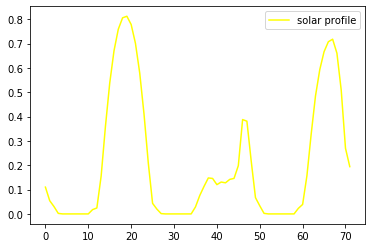

In [5]:
plt.plot(opt.sun[0], label='solar profile', color='yellow')
plt.legend()

The last input is the hourly-dependent electricity prices:

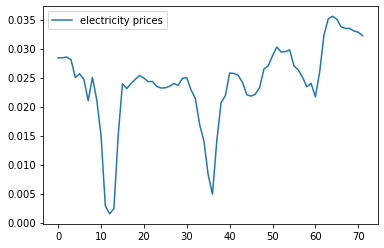

In [6]:
plt.plot(opt.price, label='electricity prices')
plt.legend()

For prosumers equipped with a battery system, one can call `opt.optimize(u)` to calculate the best usage of the battery over the time period, the function returns the calculated cost over the period considering the battery level follows the calculated decisions:

optimal cost is -1.06021


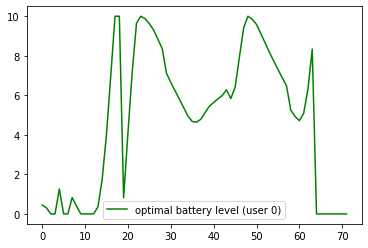

In [7]:
print("optimal cost is", opt.optimize(0))

plt.plot(opt.bat, label='optimal battery level (user 0)', color="green")
plt.legend()

Same for the 3rd user:

optimal cost is 1.84891


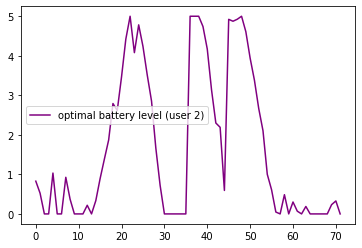

In [8]:
print("optimal cost is", opt.optimize(2))
plt.plot(opt.bat, label='optimal battery level (user 2)', color="purple")
plt.legend()

For users without a battery `optimize` is resolved without claling the LP-solver and just iterating over the input. Interactions with the grid is retrieved in `opt.el_in` and `opt.el_out`. For users without PV panels, all electricity is bought from the grid.

cost of user 1 is 5.879356283625002


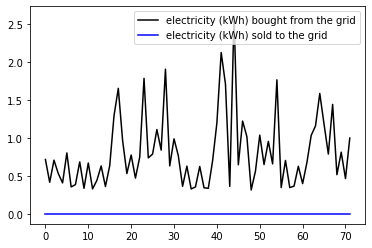

In [9]:
print("cost of user 1 is", opt.optimize(1))

plt.plot(opt.el_in, label="electricity (kWh) bought from the grid", color="black")
plt.plot(opt.el_out, label="electricity (kWh) sold to the grid", color="blue")
plt.legend()

To optimize the two users as a group, one can combine their consumptions (aggregate model) and optimize their coordinated decisions:

In [10]:
cost_community = opt.optimize_community((0,1))
print(cost_community)

2.9413


In this scenario, the base individual cost is equal to -1.06021 (for user 0) + 5.879356283625002 (for user 1):

In [11]:
cost_individual = opt.optimize()
print(cost_individual)

10.162346697187502


Hence, working as a group, the users gain a profit of:

In [12]:
cost_individual-cost_community

7.221046697187502

## Example of Matching Calculations

Let's take the data we use in the small example above and illustrate how one can calculate the best matching into 2 communities, each containing 1 prosumer and 1 consumer.

Here below a random matching is produced.

In [2]:
from matching import *
random_matching(opt)

defaultdict(list, {0: [3], 2: [1]})

Next, one can calculate the "naive" matching (matched each prosumer with first available consumers) as follows:

In [5]:
naive_matching(opt, 2)

defaultdict(list, {0: [1, 3], 2: []})

Here below how to calculate the optimal matching:

In [6]:
weights = calculate_all_pairwise_weights(opt)
optimal_pairwise_matching(opt, 2, weights)

defaultdict(list, {0: [1], 2: [3]})

The SinglePass matching goes through the prosumers and assign the k-1 consumers with best benefits (weights are calculated on the fly and memoized):

In [4]:
weights = memoized_weights(opt)
singlepass_matching(opt, 2, weights)

TypeError: <lambda>() missing 2 required positional arguments: 'p' and 'c'